## Image Classification - Distracted Driver Edition
<img src="front_page.png" style="width:250;height:250;">


### Problem Description

In this competition you are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). Your goal is to predict the likelihood of what the driver is doing in each picture. 

The 10 classes to predict are as follows,
<br>
<br>
<table>
    <tr>
        <td>
            <li>c0: safe driving</li>
            <br>
            <li>c1: texting - right</li>
            <br>
            <li>c2: talking on the phone - right</li>
            <br>
            <li>c3: texting - left</li>
            <br>
            <li>c4: talking on the phone - left</li>
            <br>
            <li>c5: operating the radio</li>
            <br>
            <li>c6: drinking</li>
            <br>
            <li>c7: reaching behind</li>
            <br>
            <li>c8: hair and makeup</li>
            <br>
            <li>c9: talking to passenger</li>
        </td>
        <td>
           <img src="driver.gif" style="width:300;height:300px;">
        </td>
    </tr>

</table>


### Summary of Results

Using a 50-layer Residual Network (with the following parameters) the following scores (losses) were obtained.
<table> 
<li>50 Epochs</li>
<li>32 Batch Size</li>
<li>Adam Optimizer</li>
<li>Glorot Uniform Initializer</li>
    <tr> 
        <td>
            **Training Score**
        </td>
        <td>
         0.0127
        </td>
    </tr>
    <tr> 
        <td>
            **Validation Score**
        </td>
        <td>
        0.0472
        </td>
    </tr>
    <tr> 
        <td>
            **Holdout Score**
        </td>
        <td>
         3.2267
        </td>
    </tr>
</table>

The large difference in validation score and holdout score are primarily due to the difference in calculation of loss between the loss function used to train the model (sparse_categorical_crossentropy) vs. the competition's loss function (multi-class logarithmic loss).

### Import Dependencies and Define Functions

Let's begin by importing some useful dependencies and defining some key functions that we'll use throughout the notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
                          Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model, load_model, save_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn.model_selection import StratifiedKFold, cross_validate

from PIL import Image

Using TensorFlow backend.


In [66]:
def PlotClassFrequency(class_counts):
    plt.figure(figsize=(15,4))
    plt.bar(class_counts.index,class_counts)
    plt.xlabel('class')
    plt.xticks(np.arange(0, 10, 1.0))
    plt.ylabel('count')
    plt.title('Number of Images per Class')
    plt.show()

def DescribeImageData(data):
    print('Average number of images: ' + str(np.mean(data)))
    print("Lowest image count: {}. At: {}".format(data.min(), data.idxmin()))
    print("Highest image count: {}. At: {}".format(data.max(), data.idxmax()))
    print(data.describe())
    
def CreateImgArray(height, width, channel, data, folder, save_labels = True):
    """
    Writes image files found in 'imgs/train' to array of shape
    [examples, height, width, channel]
    
    Arguments:
    height -- integer, height in pixels
    width --  integer, width in pixels
    channel -- integer, number of channels (or dimensions) for image (3 for RGB)
    data -- dataframe, containing associated image properties, such as:
            subject -> string, alpha-numeric code of participant in image
            classname -> string, the class name i.e. 'c0', 'c1', etc. 
            img -> string, image name
    folder -- string, either 'test' or 'train' folder containing the images
    save_labels -- bool, True if labels should be saved, or False (just save 'X' images array).  
                   Note: only applies if using train folder
            
    Returns:
    .npy file -- file, contains the associated conversion of images to numerical values for processing
    """
    
    num_examples = len(data)
    X = np.zeros((num_examples,height,width,channel))
    if (folder == 'train') & (save_labels == True):
        Y = np.zeros(num_examples)
    
    for m in range(num_examples):
        current_img = data.img[m]
        img_path = 'imgs/' + folder + '/' + current_img
        img = image.load_img(img_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[m] = x
        if (folder == 'train') & (save_labels == True):
            Y[m] = data.loc[data['img'] == current_img, 'classname'].iloc[0]
        
    np.save('X_'+ folder + '_' + str(height) + '_' + str(width), X)
    if (folder == 'train') & (save_labels == True):
        np.save('Y_'+ folder + '_' + str(height) + '_' + str(width), Y)
        
def Rescale(X):
    return (1/(2*np.max(X))) * X + 0.5

def PrintImage(X_scaled, index, Y = None):
    plt.imshow(X_scaled[index])
    if Y is not None:
        if Y.shape[1] == 1:
            print ("y = " + str(np.squeeze(Y[index])))
        else:
            print("y = " + str(np.argmax(Y[index])))

### Quick EDA

Let's begin by loading the provided dataset 'driver_imgs_list' doing a quick analysis. 

In [47]:
driver_imgs_df = pd.read_csv('driver_imgs_list/driver_imgs_list.csv')
driver_imgs_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


We can note the number of examples by printing the shape of the dataframe. Looks like the training set has 22,424 images.

In [48]:
driver_imgs_df.shape

(22424, 3)

We can plot the number of images per class to see if any classes have a low number of images.

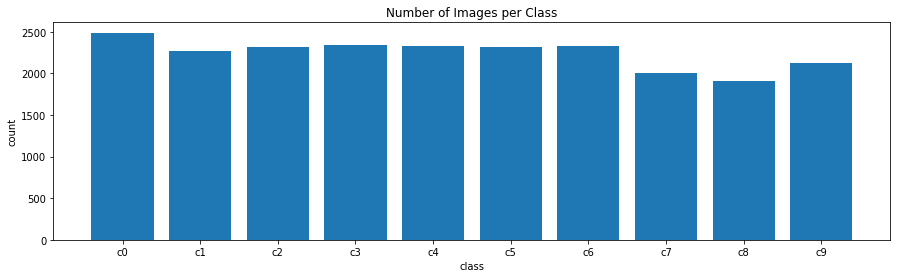

Average number of images: 2242.4
Lowest image count: 1911. At: c8
Highest image count: 2489. At: c0
count      10.000000
mean     2242.400000
std       175.387951
min      1911.000000
25%      2163.500000
50%      2314.500000
75%      2325.750000
max      2489.000000
Name: classname, dtype: float64


In [67]:
class_counts = (driver_imgs_df.classname).value_counts()
PlotClassFrequency(class_counts)
DescribeImageData(class_counts)

Additionally, we can plot the number of images per test subject. It would be much more helpful to plot the number of images belonging to each class *per subject*. We could then ensure that the distribution is somewhat uniform. We did not show this here, and instead just plotted number of images per subject.

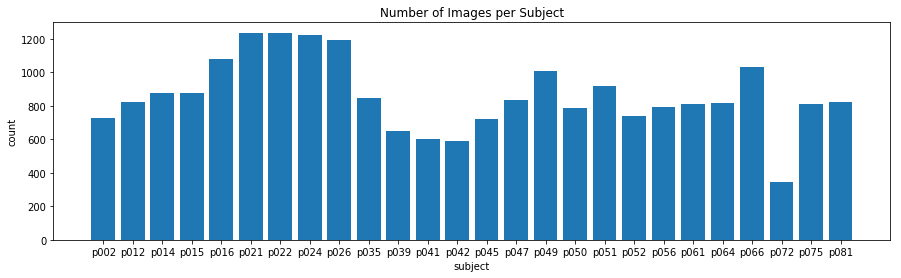

Average number of images: 862.461538462
Lowest image count: 346. At: p072
Highest image count: 1237. At: p021
count      26.000000
mean      862.461538
std       214.298713
min       346.000000
25%       752.500000
50%       823.000000
75%       988.250000
max      1237.000000
Name: subject, dtype: float64


In [68]:
subject_counts = (driver_imgs_df.subject).value_counts()
plt.figure(figsize=(15,4))
plt.bar(subject_counts.index,subject_counts)
plt.xlabel('subject')
plt.ylabel('count')
plt.title('Number of Images per Subject')
plt.show()
DescribeImageData(subject_counts)

Furthermore, we can check if there are any null image examples.

In [25]:
pd.isnull(driver_imgs_df).sum()

subject      0
classname    0
img          0
dtype: int64

### Preprocess Data

The data was provided with the classes in order (from class 0 to class 9). Let's shuffle the data by permutating the 'classname' and 'img' attributes.

In [26]:
np.random.seed(0)
myarray = np.random.permutation(driver_imgs_df[['classname','img']])
driver_imgs_df = pd.DataFrame(data = myarray, columns=['classname', 'img'])

We'll go ahead and apply a dictionary to the 'classname' attribute and assign the strings to their respective integers.

In [27]:
d = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
driver_imgs_df.classname = driver_imgs_df.classname.map(d)

### Convert Dataframe to Array for Training

Let's convert the images into numerical arrays of dimension '64, 64, 3'. Both the height and width of the images will be 64 pixels, and each image will have 3 channels (for red, green and blue). The following function saves the array as a .npy file.

In [28]:
CreateImgArray(64, 64, 3, driver_imgs_df, 'train')

Let's now load the new image arrays into the environment. Note that this step is used to save memory so that CreateImgArray does not have to be executed every time.

In [28]:
X = np.load('X_train_64_64.npy')
X.shape

(22424, 64, 64, 3)

In [29]:
Y = np.load('Y_train_64_64.npy')
Y.shape

(22424,)

Let's check our new arrays and ensure we compiled everything correctly. We can see that we do not have any entries in X that contain zero, and Y contains all the target labels.

In [31]:
(X == 0).sum()

0

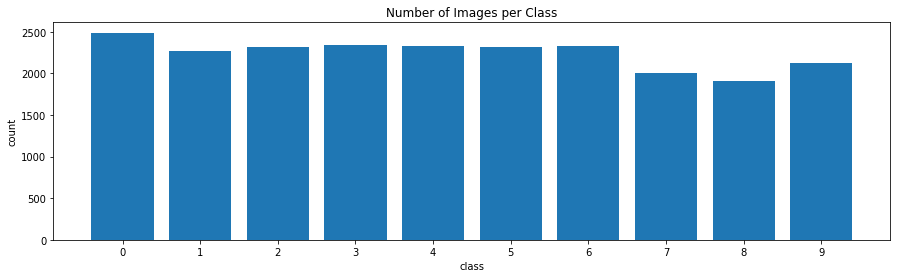

In [32]:
PlotClassFrequency(pd.DataFrame(Y)[0].value_counts())

Furthermore, we can print the images from X and the associated class as a sanity check. Re-scaling the images (between 0 and 1):

In [30]:
X_scaled = Rescale(X)

y = 3.0


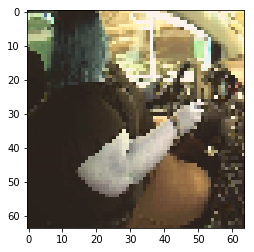

In [41]:
PrintImage(X_scaled, 423, Y = Y.reshape(-1,1))

Class of "3" corresponds to a driver "texting left", which appears to be the case shown above.

### Build the Model

We'll use the popular Residual Net with 50 layers. Residual networks are essential to preventing vanishing gradients when using a rather 'deep' network (many layers). The identity_block and convolutional_block are defined below.

In [36]:
def identity_block(X, f, filters, stage, block, init):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [37]:
def convolutional_block(X, f, filters, stage, block, init, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = init)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

With the two blocks defined, we'll now create the model ResNet50, as shown below.

In [38]:
def ResNet50(input_shape = (64, 64, 3), classes = 10, optimizer = 'adam', init = glorot_uniform(seed=0)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1, init = init)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b', init = init)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c', init = init)

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2, init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b', init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='c', init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='d', init = init)

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2, init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f', init = init)

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2, init = init)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b', init = init)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c', init = init)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = init)(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    # Compile model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Cross Validation Training

Let's do some basic transformation on the training / label arrays, and print the shapes. After, we'll define some key functions for use in our first CNN model.

In [39]:
# Normalize image vectors
X_train = X/255

# Convert training and test labels to one hot matrices
#Y = convert_to_one_hot(Y.astype(int), 10).T
Y_train = np.expand_dims(Y.astype(int), -1)

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

number of training examples = 22424
X_train shape: (22424, 64, 64, 3)
Y_train shape: (22424, 1)


In order to run cross-validation, we'll have to use a Keras wrapper to enable implementation of Scikit-Learn methods on Keras model objects. We'll pass in the epochs and batch_size parameters, starting at just 2 epochs with a batch size of 32.

In [40]:
model = KerasClassifier(build_fn=ResNet50, epochs=2, batch_size=32, verbose=0)

Defining our KFold cross-validator, and running cross_validate:

In [41]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_validate(model, X_train, Y_train, cv=kfold, return_train_score=True)

In [42]:
print("Train score: {}. Dev. score: {}".format(scores['train_score'].mean(), scores['test_score'].mean()))
print("Fit time: {}. Score time: {}".format(scores['fit_time'].sum(), scores['score_time'].sum()))

Train score: 0.41460989593849246. Dev. score: 0.40951957870293915
Fit time: 651.6005990505219. Score time: 20.628852367401123


We can note that the train score is higher than the dev score, which is expected. The accuracy is quite low in comparison to our assumed Bayes accuracy of 100% (using human accuracy as a proxy to Bayes). Let's try increasing the number of epochs to 5 and observe if the train/dev scores increase.

In [45]:
model = KerasClassifier(build_fn=ResNet50, epochs=5, batch_size=32, verbose=0)

In [46]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_validate(model, X_train, Y_train, cv=kfold, return_train_score=True)

In [47]:
print("Train score: {}. Dev. score: {}".format(scores['train_score'].mean(), scores['test_score'].mean()))
print("Fit time: {}. Score time: {}".format(scores['fit_time'].sum(), scores['score_time'].sum()))

Train score: 0.6748876264259673. Dev. score: 0.6665730423047045
Fit time: 1546.9933955669403. Score time: 26.11343479156494


The train and dev score increased to 67.5% and 66.7%, respectively. We can note that we still have an underfitting problem (high bias, about 32.5%), with very little generalization issues considering that the difference between train/dev scores is approximately 0.8% (variance). 

In order to tackle **high bias**, we can do any of the following:
<li>run more epochs</li>
<li>increase the batch size (up to number of examples)</li>
<li>make a deeper network</li>
<li>increases the image size from 64x64 to 128x128, 256x256, etc.</li>

Let's just bump it up to 50 epochs. Considering the increase in run time (from 5 epochs to 50, or roughly about 1500s times 10, which equates to roughly 4 hours run time), let's forgo cross-validation with 'k' folds. Instead, we'll train with a single train/dev split and observe the train/dev accuracy trends over epochs. In practice, we'd continue with 5-10 folds so as to get an accurate distribution of the trian/dev scores.

### Training with a Single Train/Dev Split

#### 50 Epochs, Batch Size 32

If we had more resources, we'd simply run K-fold cross-validation (5-10 folds) and plot a learning curve to inspect our bias/variance. Considering our limited resources, let's re-define the model and cross-validate with a single train/dev split, and just observe the train/dev scores over epochs.

In [60]:
model = ResNet50(input_shape = (64, 64, 3), classes = 10)

This time, we'll set the validation_split argument to 30%. We should feel pretty confident on the validation results, as we're testing on about 6700 images.

In [61]:
model.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_split = 0.3)

Train on 15696 samples, validate on 6728 samples
Epoch 1/50
15696/15696 [==============================] - 72s 5ms/step - loss: 2.3200 - acc: 0.3443 - val_loss: 1.5759 - val_acc: 0.6011
Epoch 2/50
15696/15696 [==============================] - 60s 4ms/step - loss: 1.3127 - acc: 0.6895 - val_loss: 0.9300 - val_acc: 0.8334
Epoch 3/50
15696/15696 [==============================] - 59s 4ms/step - loss: 1.7795 - acc: 0.5379 - val_loss: 1.4507 - val_acc: 0.6222
Epoch 4/50
15696/15696 [==============================] - 60s 4ms/step - loss: 1.2156 - acc: 0.7116 - val_loss: 1.5753 - val_acc: 0.6201
Epoch 5/50
15696/15696 [==============================] - 60s 4ms/step - loss: 0.9776 - acc: 0.8050 - val_loss: 1.3532 - val_acc: 0.6684
Epoch 6/50
15696/15696 [==============================] - 60s 4ms/step - loss: 1.1482 - acc: 0.7287 - val_loss: 1.8698 - val_acc: 0.4949
Epoch 7/50
15696/15696 [==============================] - 60s 4ms/step - loss: 1.4504 - acc: 0.6430 - val_loss: 1.1710 - val_acc:

Saving the model:

In [66]:
save_model(model, 'model_e50.h5')

Let's plot the result, as shown below:

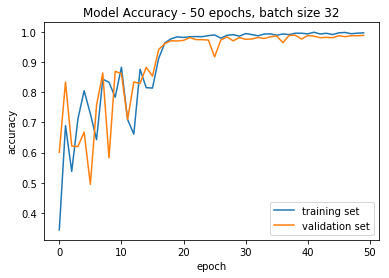

In [65]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy - 50 epochs, batch size 32')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

From the above figure, we can note the model begins to plateau around 40 epochs. Judging by this figure, increasing the number of epochs will have little effect on the accuracy/loss with the current hyper parameters.

#### Loading a Model

To save memory, we can restart the kernal and simply load any model back into the namespace, as such:

In [3]:
model = load_model('model_e50.h5') 

### Predictions on the Holdout Set (and Kaggle Submission)

Let's load the holdout data set from out 'test_file_names' csv file and then create the necessary array.

In [ ]:
holdout_imgs_df = pd.read_csv('test_file_names.csv')
holdout_imgs_df.rename(columns={"imagename": "img"}, inplace = True)

In [ ]:
CreateImgArray(64, 64, 3, holdout_imgs_df, 'test')

Again, we'll load the data here instead of having to run CreateImgArray repeatedly. 

In [4]:
X_holdout = np.load('X_test_64_64.npy')
X_holdout.shape

(79726, 64, 64, 3)

And now calling predictions on the holdout set,

In [5]:
predictions = model.predict(X_holdout, batch_size = 32)

Saving the predictions to a .csv file for submission,

In [6]:
np.savetxt("test_results.csv", predictions, delimiter=",")

Submitting the results to Kaggle, we obtain a **score of 3.22670**. Not bad with a standard 50-layer residual network with no parameter changes. The best score obtained during the duration of the competition was around 0.08.
<br>
<img src="kaggle_sub.png" style="width:400;height:400px;">

If desired (as a sanity check) we can visually check our predictions by scaling the X_holdout array and then printing the image.

In [7]:
X_holdout_scaled = Rescale(X_holdout)

y = 8


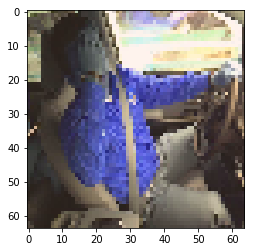

In [45]:
PrintImage(X_holdout_scaled, index = 23, Y = predictions)

### Ways to Improve the Model

If we're going to assume we can't beat 99.66% accuracy, then we're dealing with **high variance** (0.83% between dev and train). Note that we would generally report confidence intervals for the variance, but we only ran one cv split!

<li>Augment images to increase sample size</li>
<li>Regularization</li>
<li>GridSearching over params (batch size, epoch, optimizer and it's parameters, initializer)</li>
<li>Decrease dev set size (allows more examples to be trained, making model less prone to overfitting)</li>
<li>Ensure even distribution of test subjects to class (we do not want a particular subject taking the majority of a class, as the model will relate that class to the subject, thus becoming bias towards that subject for that given class).</li>
<li>Investigate classes with low accuracy, and fix them</li>